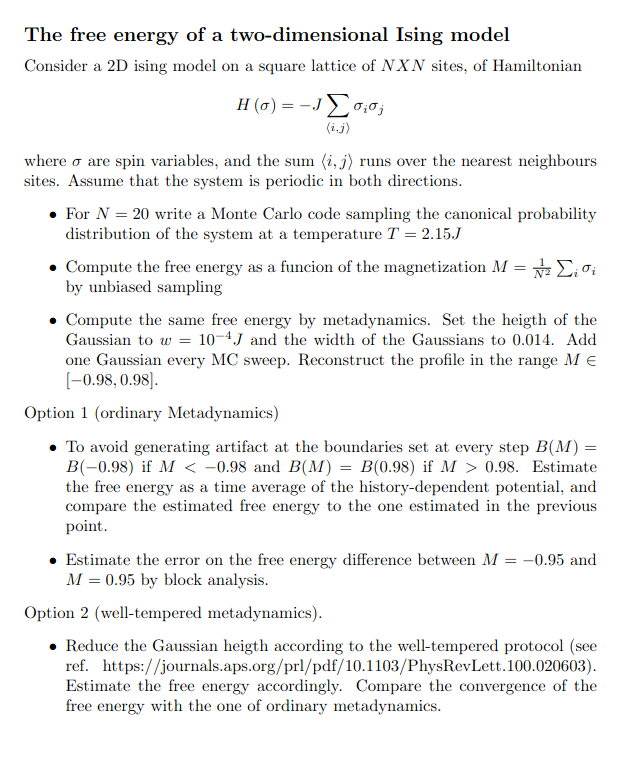

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Define parameters 
N = 20 # Number of sites along one dimension
J = 1 # Coupling constant
kbT = 2.15*J # Temperature
n_steps = 10000 # Default number of time steps

In [26]:
# Define the Hamiltonian
def H(spins, J):
    ''' Returns the Hamiltonian of the system. It is computed as the sum of the interactions between nearest neighbours. '''
    # Compute interaction with each neighbour in a parallelised fashion by matrices element-wise multiplication. np.roll accounts for PBCs.
    H = spins*np.roll(spins,1, axis=1) + spins*np.roll(spins,-1, axis=1) + spins*np.roll(spins,-1, axis=0) + spins*np.roll(spins,1, axis=0)
    return -J*H

# Define magnetisation
def M_compute(spins):
    ''' Returns the total magnetisation of the system, divided by the number of sites. '''
    return np.sum(spins)

Unbiased Simulation

In [4]:
# Metropolis with unbiased potential
# Si potrebbe ottimizzare calcolando l'energia solo per i primi vicini, tanto solo loro cambiano
def run_unbiased(n_steps, spins = None):
    if spins is None:
        spins = np.random.choice([-1,1], size=(N,N)) # Random initial configuration
    E_0 = np.sum(H(spins, J)) # Initial energy
    # Si potrebbe ottimizzare calcolando l'energia solo per i primi vicini, tanto solo loro cambiano
    M_time_series = [ M_compute(spins), ] # List to store the magnetisation at each time step

    acceptance = 0
    for _ in tqdm(range(n_steps)):
        # Move is proposed by flipping a random spin
        proposed_spins = spins.copy()
        # Randomly choose a spin to flip
        i = np.random.randint(N)
        j = np.random.randint(N)
        proposed_spins[i,j] *= -1
        # Compute the new energy
        E_proposed = np.sum(H(proposed_spins, J))
        alpha = np.exp(-(E_proposed-E_0)/kbT) # Acceptance computed as ratio of probabilities. Proposal matrix is symmetric, so it cancels out
        alpha = min(1, alpha)
        # Accept or reject the move
        if np.random.random() < alpha:  # Accept
            spins = proposed_spins
            E_0 = E_proposed
            acceptance += 1
        else: # Reject
            pass
        M_time_series.append(M_compute(spins))
    
    print(f'Acceptance rate: {acceptance/n_steps}')

    return M_time_series


In [15]:
M_time_series = run_unbiased(n_steps=200000)

100%|██████████| 200000/200000 [00:21<00:00, 9173.72it/s]


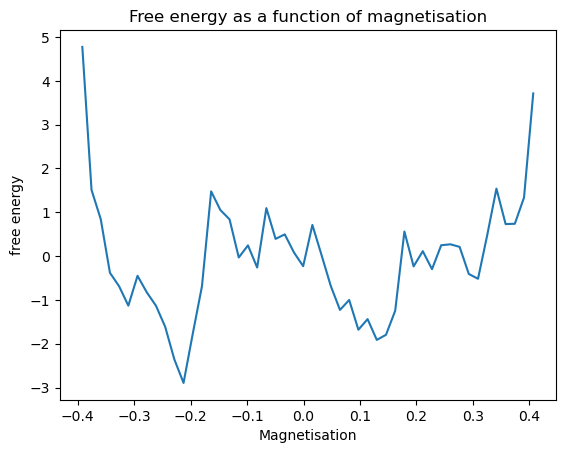

In [21]:
# Histogram of free energy as a function of magnetisation
# Free energy is computed as -kbT*log(p(m))
# p(m) is computed as the histogram of the magnetisation time series

# Compute histogram
hist, bin_edges = np.histogram(M_time_series, bins=50, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
# Compute free energy
free_energy = -kbT*np.log(hist)

# Plot
plt.plot(bin_centers, free_energy)

plt.xlabel('Magnetisation')
plt.ylabel('free energy')
plt.title('Free energy as a function of magnetisation')
plt.show()

Metadynamics run

In [30]:
# Metadynamics params
w = 1e-4*J # Height of the Gaussian
width = 0.014 # Width of the Gaussian
M_domain = np.arange(-N**2,N**2+1) # Domain of the magnetisation


In [31]:
def add_gaussian(bias,M,w,width):
    ''' Adds a Gaussian centered on M(spins) to the bias potential. '''
    # Compute gaussian centered on M on each x
    gaussian = w*np.exp(-(M_domain-M)**2/(2*width**2))
    # Add the Gaussian to the bias potential
    bias += gaussian
    return bias
    

# Metadynamics
def run_metadynamics(n_steps, spins = None):
    if spins is None:
        spins = np.random.choice([-1,1], size=(N,N)) # Random initial configuration
    E_0 = np.sum(H(spins, J)) # Initial energy
    # Si potrebbe ottimizzare calcolando l'energia solo per i primi vicini, tanto solo loro cambiano
    M = M_compute(spins) # Initial magnetisation
    M_time_series = [ M, ] # List to store the magnetisation at each time step

    # BIAS
    bias = np.zeros(N**2) # Bias potential as a function of magnetisation

    acceptance = 0
    for _ in tqdm(range(n_steps)):
        # Move is proposed by flipping a random spin
        proposed_spins = spins.copy()
        # Randomly choose a spin to flip
        i = np.random.randint(N)
        j = np.random.randint(N)
        proposed_spins[i,j] *= -1
        # Compute the new energy and magnetisation
        E_proposed = np.sum(H(proposed_spins, J))
        M_proposed = M_compute(proposed_spins) # Anche questo si potrebbe ottimizzare
        
        # Compute the acceptance
        # Get the bias at the current magnetisation
        delta_E = E_proposed-E_0 + bias[M_proposed] - bias[M]
        alpha = np.exp(-delta_E/kbT) # Acceptance computed as ratio of probabilities. Proposal matrix is symmetric, so it cancels out
        alpha = min(1, alpha)
        # Accept or reject the move
        if np.random.random() < alpha:  # Accept
            spins = proposed_spins
            E_0 = E_proposed
            acceptance += 1
        else: # Reject
            pass
        
        # Update bias for each spin
        M = M_compute(spins)
        bias = add_gaussian(bias,M,w,width)

        M_time_series.append(M)
    
    print(f'Acceptance rate: {acceptance/n_steps}')

    return M_time_series, bias

In [32]:
M_time_series, bias = run_metadynamics(n_steps=200000)

  0%|          | 0/200000 [00:00<?, ?it/s]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# Plot bias potential